# 🚀 LangGraph Quickstart¶

Trong hướng dẫn này, chúng ta sẽ xây dựng một chatbot hỗ trợ trong LangGraph có thể:

- ✅ Trả lời các câu hỏi thường gặp bằng cách tìm kiếm trên web
- ✅ Duy trì trạng thái hội thoại giữa các lần gọi
- ✅ Định tuyến các truy vấn phức tạp đến con người để xem xét
- ✅ Sử dụng trạng thái tùy chỉnh để kiểm soát hành vi của nó
- ✅ Tua lại và khám phá các đường dẫn hội thoại thay thế

Chúng ta sẽ bắt đầu với một chatbot cơ bản và dần dần thêm các khả năng phức tạp hơn, giới thiệu các khái niệm chính của LangGraph trên đường đi. Hãy cùng bắt đầu! 🌟


## Setup

In [1]:
import os
import langgraph
from langchain_ollama import ChatOllama

### Part 1: Build a Basic Chatbot

Chúng ta sẽ bắt đầu bằng cách tạo một chatbot đơn giản sử dụng LangGraph. Chatbot này sẽ phản hồi trực tiếp các tin nhắn của người dùng. Mặc dù đơn giản, nó sẽ minh họa các khái niệm cốt lõi của việc xây dựng với LangGraph. Đến cuối phần này, bạn sẽ có một chatbot thô sơ.

Bắt đầu bằng cách tạo một `StateGraph`. Đối tượng `StateGraph` định nghĩa cấu trúc của chatbot của chúng ta như một "máy trạng thái" (state machine). Chúng ta sẽ thêm `nodes` để đại diện cho `llm` và các functions mà chatbot có thể gọi, và `edges` để chỉ định cách bot nên chuyển đổi giữa các functions này.


In [2]:
from typing import Annotated # được sử dụng để thêm metadata vào chú thích.
from typing_extensions import TypedDict # được sử dụng để tạo các dictionary types với các khóa và giá trị được chú thích.

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# Định nghĩa một lớp State kế thừa từ TypedDict. 
# Điều này có nghĩa là State là một kiểu từ điển với các khóa và giá trị được chú thích kiểu.
class State(TypedDict):
  # messages: Đây là một khóa trong từ điển State.
  # Annotated[list, add_messages]: Điều này có nghĩa là giá trị của khóa messages là một danh sách (list).
  # add_messages: Đây là metadata được thêm vào chú thích kiểu. 
  # Nó cho biết rằng danh sách messages sẽ được sử dụng để lưu trữ các thông điệp và hàm add_messages sẽ được sử dụng để thêm các thông điệp vào danh sách.
  messages: Annotated[list, add_messages]
  
graph_builder = StateGraph(State)


Đồ thị của chúng ta giờ đây có thể xử lý hai nhiệm vụ chính:

* Mỗi **node** có thể nhận **State** hiện tại làm đầu vào và xuất ra bản cập nhật cho state đó.
* Các bản cập nhật cho **message** sẽ được thêm vào danh sách hiện có thay vì ghi đè, nhờ hàm **add\_messages** dựng sẵn được sử dụng với cú pháp **Annotated**.

> Khi định nghĩa một đồ thị, bước đầu tiên là định nghĩa **State** của nó. **State** bao gồm schema của đồ thị và các **reducer function** xử lý cập nhật state. Trong ví dụ của chúng ta, **State** là một **TypedDict** với một key: **messages**. **reducer function** **add\_messages** được sử dụng để thêm các message mới vào danh sách thay vì ghi đè. Các key không có chú thích reducer sẽ ghi đè các giá trị trước đó.


Next, add a "chatbot" node. Nodes represent units of work. They are typically regular python functions.

In [3]:
llm_model_name='qwen2.5:7b'
llm = ChatOllama(model=llm_model_name, temperature=0)

def chatbot(state: State):
  return {"messages": [llm.invoke(state['messages'])]}

graph_builder.add_node("chatbot", chatbot)

Notice how the chatbot node function takes the current State as input and returns a dictionary containing an updated messages list under the key `"messages"`. This is the basic pattern for all `LangGraph` node functions.

The `add_messages` function in our `State` will append the llm's response messages to whatever messages are already in the state.

Next, add an entry point. This tells our graph where to start its work each time we run it.

In [4]:
graph_builder.add_edge(START, "chatbot")

In [5]:
graph_builder.add_edge('chatbot', END)

Finally, we'll want to be able to run our graph. To do so, call `"compile()"` on the graph builder. This creates a `"CompiledGraph"` we can use invoke on our state.

In [6]:
graph = graph_builder.compile()

You can visualize the graph using the `get_graph` method and one of the "`draw`" methods, like `draw_ascii` or `draw_png`. The draw methods each require additional dependencies.

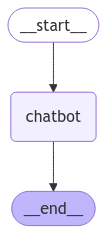

In [7]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except:
  pass

Now let's run the chatbot!

Tip: You can exit the chat loop at any time by typing "`quit`", "`exit`", or "`q`".

In [8]:
def stream_graph_updates(user_input: str):
  for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
    # print(f"event values: {event.values()}")
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)


# while True:
#     try:
#         user_input = input("User: ")
#         if user_input.lower() in ["quit", "exit", "q"]:
#             print("Goodbye!")
#             break

#         stream_graph_updates(user_input)
#     except:
#         # fallback if input() is not available
#         user_input = "What do you know about LangGraph?"
#         print("User: " + user_input)
#         stream_graph_updates(user_input)
#         break

In [9]:
stream_graph_updates("Hello world")

Assistant: Hello! How can I assist you today?


### Full code

In [10]:
from typing import Annotated

from langchain_ollama import ChatOllama
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm_model_name='qwen2.5:7b'
llm = ChatOllama(model=llm_model_name, temperature=0)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

### Part 2: 🛠️ Enhancing the Chatbot with Tools

To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool. Our bot can use this tool to find relevant information and provide better responses.

Requirements
Before we start, make sure you have the necessary packages installed and API keys set up:

First, install the requirements to use the Tavily Search Engine, and set your `TAVILY_API_KEY`.

```bash
pip install -U tavily-python langchain_community
```

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
load_dotenv(dotenv_path='.env')

tool = TavilySearchResults(max_results=2)
tools = [tool]


In [12]:
tool.invoke("what is a node in langgraph")

[{'title': 'LangGraph Glossary - GitHub Pages',
  'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id).\nSimilar to NetworkX, you add these nodes to a graph using the add_node method:\n[](https://langchain-ai.github.io/langgraph/concepts/low_level/#__codelineno-7-1)from langchain_core.runnables import RunnableConfig [...] By composing Nodes and Edges, you can create complex, looping workflows that evolve the State over time. The real power, though, comes from how LangGraph manages that State. To emphasize: Nodes and Edges are nothing more than Python functions - they can contain an LLM or just good ol\' Python code.\nIn short: nodes do the work. edges tell what to do next.',
  'score': 0.8535788385819522},
 {'ti

In [13]:
from langchain_community.tools import DuckDuckGoSearchResults

ddTool = DuckDuckGoSearchResults(max_results=2)
ddTool.invoke("what is a node in langgraph")

ddtools = [ddTool]

In [14]:
from typing import Annotated
from langchain_ollama import ChatOllama
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOllama(model='qwen2.5:7b', temperature=0)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)


Tiếp theo, chúng ta cần tạo một hàm để thực sự chạy các công cụ nếu chúng được gọi. Chúng ta sẽ làm điều này bằng cách thêm các công cụ vào một node mới.

Dưới đây, chúng ta triển khai một `BasicToolNode` để kiểm tra tin nhắn gần đây nhất trong trạng thái và gọi các công cụ nếu tin nhắn chứa `tool_calls`. Nó dựa vào hỗ trợ `tool_calling` của LLM, có sẵn trong Anthropic, OpenAI, Google Gemini và một số nhà cung cấp LLM khác.

Sau này, chúng ta sẽ thay thế nó bằng `ToolNode` được xây dựng sẵn của LangGraph để tăng tốc độ, nhưng việc tự xây dựng nó trước tiên sẽ rất hữu ích.


In [15]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)


Với node `tool` đã được thêm vào, chúng ta có thể định nghĩa `conditional_edges`.

Nhớ rằng `edges` định tuyến luồng điều khiển từ một node này sang node tiếp theo. `Conditional edges` thường chứa các câu lệnh "if" để định tuyến đến các node khác nhau tùy thuộc vào trạng thái đồ thị hiện tại. Các hàm này nhận `state` đồ thị hiện tại và trả về một chuỗi hoặc danh sách các chuỗi chỉ ra node nào sẽ được gọi tiếp theo.

Dưới đây, hãy định nghĩa một hàm router gọi là `route_tools`, kiểm tra `tool_calls` trong đầu ra của chatbot. Cung cấp hàm này cho đồ thị bằng cách gọi `add_conditional_edges`, cho đồ thị biết rằng bất cứ khi nào node `chatbot` hoàn thành, hãy kiểm tra hàm này để xem nên đi đâu tiếp theo.

Điều kiện sẽ định tuyến đến `tools` nếu có `tool calls` và `END` nếu không.

Sau này, chúng ta sẽ thay thế điều này bằng `tools_condition` được xây dựng sẵn để ngắn gọn hơn, nhưng việc tự triển khai trước tiên sẽ làm mọi thứ rõ ràng hơn.


In [16]:
def route_tools(state: State,):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

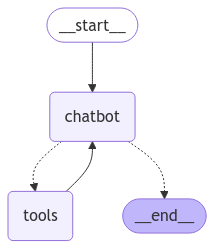

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now we can ask the bot questions outside its training data.


In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        # print(f"event values: {event.values()}")
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
        
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: [{"title": "LangChain: Build AI Solutions with Node.js - A Comprehensive Guide", "url": "https://medium.com/widle-studio/building-ai-solutions-with-langchain-and-node-js-a-comprehensive-guide-widle-studio-4812753aedff", "content": "1. Understanding LangChain\n1.1 What is LangChain?\nLangChain is a Node.js library that empowers developers with powerful natural language processing capabilities. It leverages advanced AI algorithms and models to perform tasks like text tokenization, part-of-speech tagging, named entity recognition, language translation, and sentiment analysis. Developers can build sophisticated NLP applications effortlessly with the simplicity and efficiency of LangChain's APIs.\n1.2 Key Features of LangChain [...] Before we start using LangChain, we need to have Node.js installed on our system. Node.js is a JavaScript runtime that enables us to run JavaScript code outside the browser. Visit the official Node.js website (https://nodejs.org) and downl

### Full code

In [2]:
from typing import Annotated

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from dotenv import load_dotenv
load_dotenv()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOllama(model='qwen2.5:7b', temperature=0)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

### Part 3: Adding Memory to the Chatbot

Chatbot của chúng tôi giờ đây có thể sử dụng các công cụ để trả lời câu hỏi của người dùng, nhưng nó không ghi nhớ ngữ cảnh của các tương tác trước đó. Điều này hạn chế khả năng của nó trong việc có các cuộc hội thoại mạch lạc, nhiều lượt.

LangGraph giải quyết vấn đề này thông qua **checkpointing** liên tục. Nếu bạn cung cấp một **checkpointer** khi biên dịch đồ thị và một **thread_id** khi gọi đồ thị của bạn, LangGraph sẽ tự động lưu trạng thái sau mỗi bước. Khi bạn gọi lại đồ thị bằng cùng **thread_id**, đồ thị sẽ tải trạng thái đã lưu của nó, cho phép chatbot tiếp tục từ nơi nó đã dừng lại.

Chúng ta sẽ thấy sau này rằng **checkpointing** mạnh mẽ hơn nhiều so với bộ nhớ trò chuyện đơn giản - nó cho phép bạn lưu và tiếp tục trạng thái phức tạp bất cứ lúc nào để phục hồi lỗi, quy trình làm việc có sự tham gia của con người (human-in-the-loop), tương tác du hành thời gian (time travel interactions) và hơn thế nữa. Nhưng trước khi chúng ta đi quá xa, hãy thêm checkpointing để cho phép các cuộc hội thoại nhiều lượt.

Để bắt đầu, hãy tạo một **MemorySaver** checkpointer.
